<a href="https://colab.research.google.com/github/Khal-Ramaus/synapsis/blob/main/Next_Production_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima
!pip install numpy==1.23.5
# !pip install --force-reinstall --no-cache-dir pmdarima

In [ ]:
pip install numpy==1.25.2 scipy==1.11.1 scikit-learn==1.3.0 pmdarima

**Import all packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings

In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

I only extract data from daily_production_metrics from 2025-04-29 because there are no rainfall and temperature data before that. Also I limit the data until 2025-07-01 because there are no production data after that

In [19]:
# Data Preprocessing
df = pd.read_csv("/content/data to predict.csv")
df['date'] = pd.to_datetime(df['date'])
# Date become index
df.set_index('date', inplace=True)
# total_tons_mined_daily has coma so that pandas will read it as object
# change total_tons_mined_daily to string and remove coma
df['total_tons_mined_daily'] = df['total_tons_mined_daily'].astype(str).str.replace(',', '', regex=False)
# COnvert it to numeric
df['total_tons_mined_daily'] = pd.to_numeric(df['total_tons_mined_daily'], errors='coerce')

# CHeck if there is null value
if df['total_tons_mined_daily'].isnull().any():
    print("Warning: Missing values found in 'total_tons_mined_daily'. Filling with forward fill.")
    df['total_tons_mined_daily'].fillna(method='ffill', inplace=True) # fill with previous value


print(f"Data shape after preprocessing: {df.shape}")
df.head()

Data shape after preprocessing: (62, 8)


,total_tons_mined_daily,average_quality_grade,equipment_utilization_pct,total_fuel_consumed_daily,fuel_efficiency,daily_rainfall_mm,average_temp_daily,is_rainy_day
date,,,,,,,,
2025-04-30,2068.82,4.88,26.67,151.89,0.07,0.0,0.0,False
2025-05-01,1834.75,4.08,29.17,166.23,0.09,0.0,0.0,False
2025-05-02,2131.15,4.47,29.17,182.42,0.09,0.0,0.0,False
2025-05-03,2139.25,5.32,43.33,238.11,0.11,0.0,0.0,False
2025-05-04,1662.41,3.82,34.17,226.98,0.14,0.0,0.0,False


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2025-04-30 to 2025-06-30
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   total_tons_mined_daily     62 non-null     float64
 1   average_quality_grade      62 non-null     float64
 2   equipment_utilization_pct  62 non-null     float64
 3   total_fuel_consumed_daily  62 non-null     float64
 4   fuel_efficiency            62 non-null     float64
 5   daily_rainfall_mm          62 non-null     float64
 6   average_temp_daily         62 non-null     float64
 7   is_rainy_day               62 non-null     bool   
dtypes: bool(1), float64(7)
memory usage: 3.9 KB


In [21]:
print(df['total_tons_mined_daily'].describe())

count      62.000000
mean     1755.453548
std       321.456676
min       977.300000
25%      1518.177500
50%      1776.490000
75%      1959.570000
max      2529.730000
Name: total_tons_mined_daily, dtype: float64


In [ ]:
exog_columns = ['daily_rainfall_mm', 'average_temp_daily']


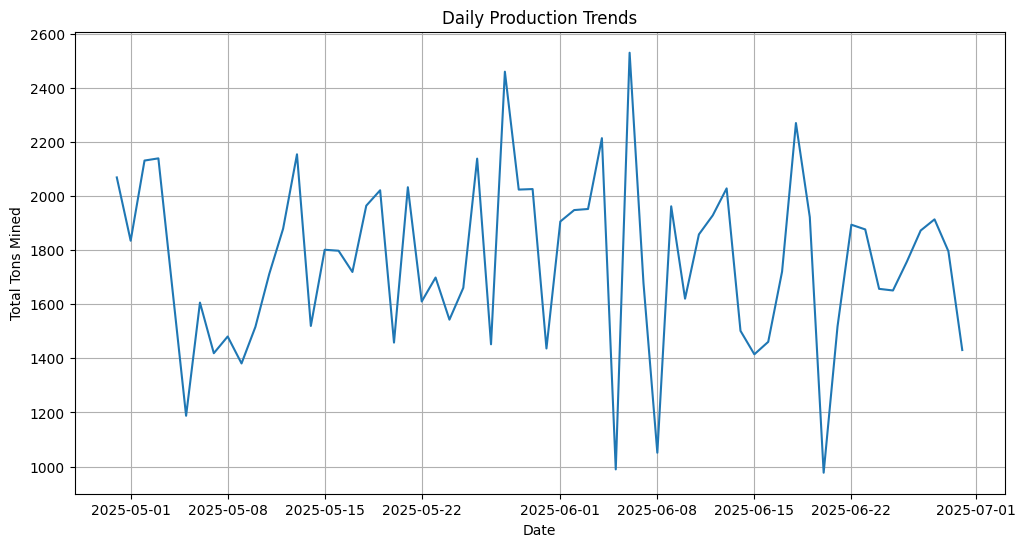

In [23]:
# EDA
plt.figure(figsize=(12, 6))
plt.plot(df['total_tons_mined_daily'])
plt.title('Daily Production Trends')
plt.xlabel('Date')
plt.ylabel('Total Tons Mined')
plt.grid(True)
plt.show()

**Split Data train and data test**

In [28]:
# ARIMA Mode train
# Split data to 80% for train and 20% for test
train_size = int(len(df) * 0.8)
train_data, test_data = df[0:train_size], df[train_size:]

print(f"\nTraining data size: {len(train_data)} rows")
print(f"Testing data size: {len(test_data)} rows")

exog_columns = ['daily_rainfall_mm'] # Kolom eksogen yang akan digunakan
train_exog = train_data[exog_columns]
test_exog = test_data[exog_columns]

print(f"Training data range: {train_data.index.min()} to {train_data.index.max()} ({len(train_data)} rows)")
print(f"Testing data range: {test_data.index.min()} to {test_data.index.max()} ({len(test_data)} rows)")


Training data size: 49 rows
Testing data size: 13 rows
Training data range: 2025-04-30 00:00:00 to 2025-06-17 00:00:00 (49 rows)
Testing data range: 2025-06-18 00:00:00 to 2025-06-30 00:00:00 (13 rows)


**Build the model for training**

In [29]:
model = auto_arima(train_data['total_tons_mined_daily'],
                   exog=train_exog,
                   start_p=1, start_q=1,
                   test='adf',       # Uji stasioneritas menggunakan ADF
                   max_p=5, max_q=5, # Batas maksimum untuk p dan q
                   m=1,              # Frekuensi musiman (m=1 jika non-seasonal, m=7 jika daily with weekly pattern)
                   d=None,           # Biarkan auto_arima menentukan 'd'
                   seasonal=False,   # Atur ke True jika ada musiman, lalu sesuaikan 'm'
                   trace=True,       # Cetak proses fitting
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)    # Gunakan algoritma stepwise

print("\nBest ARIMA Model Parameters:")
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=875.120, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=751.008, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=711.030, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=709.598, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=711.117, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=713.188, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.540 seconds

Best ARIMA Model Parameters:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   49
Model:                        SARIMAX   Log Likelihood    

**Evaluation**

In [30]:
# Evaluation
# Model Testing
forecast_steps = len(test_data)
predictions = model.predict(n_periods=forecast_steps)
predictions_series = pd.Series(predictions, index=test_data.index)

# Evaluation Metric
rmse = sqrt(mean_squared_error(test_data['total_tons_mined_daily'], predictions_series))
mae = mean_absolute_error(test_data['total_tons_mined_daily'], predictions_series)

print(f"\nModel Evaluation on Test Data:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Model Evaluation on Test Data:
Root Mean Squared Error (RMSE): 298.53
Mean Absolute Error (MAE): 214.84


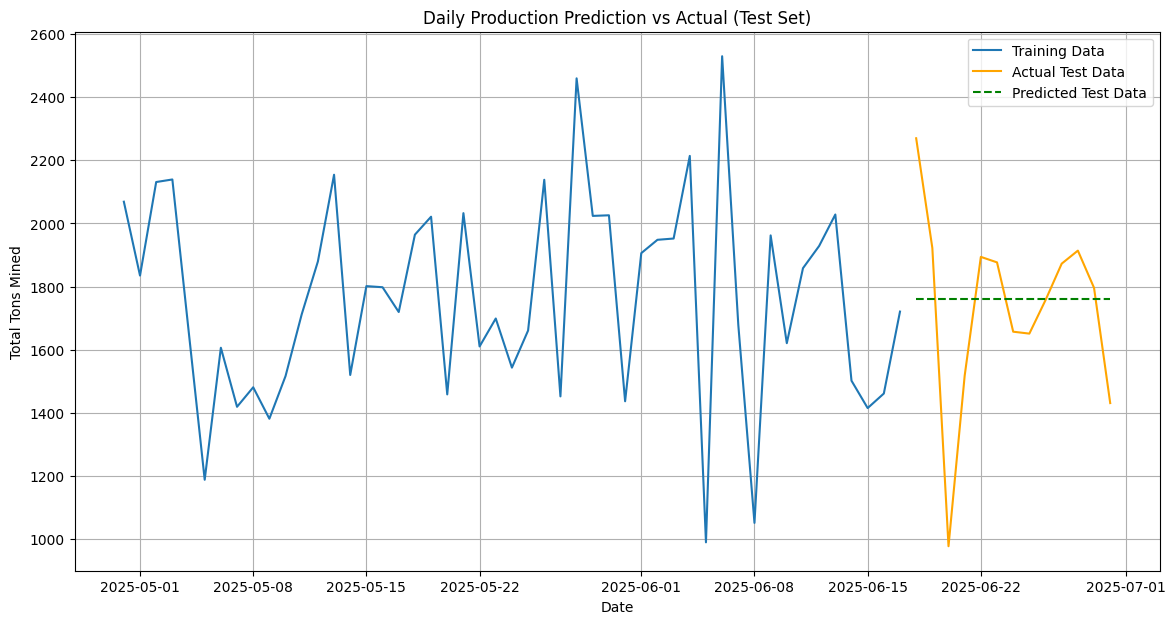

In [31]:
# Prediction Visualization
plt.figure(figsize=(14, 7))
plt.plot(train_data['total_tons_mined_daily'], label='Training Data')
plt.plot(test_data['total_tons_mined_daily'], label='Actual Test Data', color='orange')
plt.plot(predictions_series, label='Predicted Test Data', color='green', linestyle='--')
plt.title('Daily Production Prediction vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Total Tons Mined')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Next Day Production
final_model = auto_arima(df['total_tons_mined_daily'],
                   exog=df[exog_columns],
                   start_p=1, start_q=1,
                   test='adf',
                   max_p=5, max_q=5,
                   m=1,
                   d=None,
                   seasonal=False,
                   trace=False,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

In [41]:
next_day_forecast = final_model.predict(n_periods=1)

last_date_in_data = df.index.max()
next_day_date = last_date_in_data + pd.Timedelta(days=1)
print(f"\nPredicted production for {next_day_date.strftime('%Y-%m-%d')}: {next_day_forecast[0]:.2f} tons")

next_day_date = last_date_in_data + pd.Timedelta(days=2)
print(f"\nPredicted production for {next_day_date.strftime('%Y-%m-%d')}: {next_day_forecast[0]:.2f} tons")

print("\nProduction prediction model finished.")


Predicted production for 2025-07-01: 1755.45 tons

Predicted production for 2025-07-02: 1755.45 tons

Production prediction model finished.
